First some preliminaries. Import some useful packages:

In [1]:
import json
import re

import joblib
import pandas as pd
from nltk.corpus import stopwords
from nltk import ngrams
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn import tree
import pydotplus
from mlxtend.plotting import plot_decision_regions
from matplotlib import pyplot as plt


In [2]:
# to load data from Google Drive:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


To be able to display things in the notebook:

In [3]:
from IPython.display import SVG
from graphviz import Source
from IPython.display import display

    more prelims

In [4]:
# constants
SEED = 123
TEST_SIZE = .05  # the proportion of data left out of sample
# MAX_FEATURES = 7500 # the maximum number of bag of words features
N_JOBS = 11  # the number of threads to be used during training, -1 uses all processors available
DEPTH = 3  # the depth of visualization of decision tree
SVM_FEATS = 1000

Read in raw data

In [5]:
# reading in the data
obama = pd.read_csv('/content/gdrive/My Drive/Econ 484/datasets/obama_tweets.csv')
trump = pd.DataFrame(json.load(open('/content/gdrive/My Drive/Econ 484/datasets/trump_tweets.json',encoding='utf8')))

print(obama.head())
print(trump.head())

                                                Text  ...            Tweet ID
0  My heart goes out to the victims and their fam...  ...  844896595179180034
1  Chuck Berry rolled over everyone who came befo...  ...  843490091519623169
2  On International Women’s Day, @MichelleObama a...  ...  839585255703080968
3  Humbled to be recognized by a family with a le...  ...  837322131834875904
4  We asked. You answered.https://medium.com/@Oba...  ...  832675462325243906

[5 rows x 5 columns]
                                                text
0  The Wall is going up very fast despite total O...
1  Puerto Rico is one of the most corrupt places ...
2  ....And by the way, I’m the best thing that’s ...
3  Our Federal Reserve cannot “mentally” keep up ...
4  ....I don’t want to Win for myself, I only wan...


In [6]:
# adding obama indicator
obama['obama_indicator'] = 1
trump['obama_indicator'] = 0

some data cleaning

In [7]:
 # renaming names consistent for concat
obama.rename(columns={'Text': '_text'}, inplace=True)
trump.rename(columns={'text': '_text'}, inplace=True)

# concatenating data
both = pd.concat((obama.loc[:, ['_text', 'obama_indicator']], trump.loc[:, ['_text', 'obama_indicator']]))

# dropping retweets
both = both.loc[~both._text.str.contains('^RT'), :]
print('Shape of raw data:', both.shape)

# cleaning text
both._text = both._text.str.strip().str.replace('\s+', ' ').str.replace('(?:: )?https?://.+(?:\s|$)', '')
both._text = both._text.str.replace(r'\.?pic\.twitter\.com/.+(?:\s|$)', '')
both._text = both._text.str.replace(r'\d+', '')

print('data cleaned...')

both._text = both._text.str.replace(r'[…"#$%&\'\(\)*+,-./:;<=>?@\[\\\]^_`{|}~’“”—]', '')
both._text = both._text.str.replace('–|––|\s+', ' ')
both['n_cap_let'] = [len(re.findall('[A-Z]', x)) for x in both._text]
both._text = both._text.str.lower()
both._text = both._text.str.replace('trump', '')
both._text = both._text.str.replace('president obama', '')
both._text = both._text.str.replace('obama', '')
both._text = both._text.str.replace('barack', '')
both._text = both._text.str.replace('michelle', '')
both._text = both._text.str.replace('amp', '')
both._text = both._text.str.replace('ofa', '')
tknzr = TweetTokenizer()
# parsing text and dropping empty tweets after cleaning
both['tokens'] = [[re.sub('_', '', y) for y in tknzr.tokenize(x)] for x in both._text]
both = both.loc[[len(x) > 0 for x in both.tokens], :]

# generating feature variables
both['total_words'] = [len(x) for x in both.tokens]
both['avg_word_len'] = [sum([len(y) for y in x]) / len(x) for x in both.tokens]

Shape of raw data: (12681, 2)
data cleaned...


generate features

In [8]:
vectorizer = CountVectorizer(max_df=.5, min_df=.0001, stop_words='english', tokenizer=tknzr.tokenize,
                                 ngram_range=(1, 3))
bow_mat = vectorizer.fit_transform(both._text)
print('Bag of words feature set:', bow_mat.shape)

Bag of words feature set: (12563, 26475)


get ready to model

In [9]:
# modelling
dtree = DecisionTreeClassifier(random_state=SEED,max_depth=3)
dtree.fit(bow_mat, both.obama_indicator)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=123, splitter='best')

In [10]:
# visualize decision tree
dot_data = tree.export_graphviz(dtree,  feature_names=vectorizer.get_feature_names(),class_names=['Trump','Obama'],filled = True)
graph = Source(dot_data)

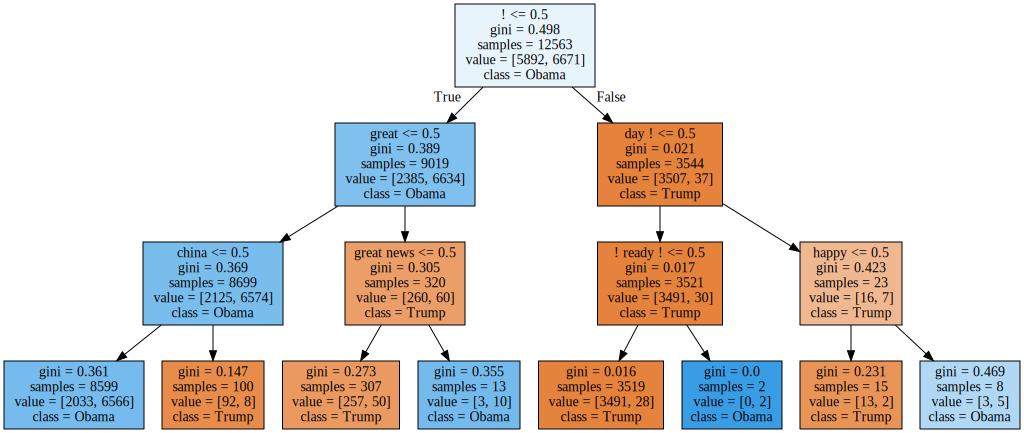

'trumpvobama.pdf'

In [11]:
display(SVG(graph.pipe(format='svg')))
graph.render('trumpvobama')

Try a new tweet:

In [13]:
new_tweet='May God bless the memory of those we lost and protect those who remain in harms way'
new_feats=vectorizer.transform([new_tweet])
dtree.predict_proba(new_feats)

array([[0.23642284, 0.76357716]])

In [ ]:
print(new_feats)